##### Created on 04/14/2022

##### This notebook is to get the GCM wind vs M relationship for the oceans over 30N to 70N. Will be compared with MERRA2+MAC and PPE outputs. Improving GCMwindVsM to omit the spike at 0.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap
from readGCMs import read_var_mod
import calendar
from global_land_mask import globe
import glob

In [2]:
modname = ['CESM2','CNRM-CM6-1', 'CanESM5','CESM2-WACCM','E3SM-1-0',
           'HadGEM3-GC31-LL','IPSL-CM6A-LR','NorESM2-LM', 'SAM0-UNICON',
           'ACCESS-CM2','ACCESS-ESM1-5','CNRM-ESM2-1','EC-Earth3',
           'EC-Earth3-Veg','FGOALS-f3-L','GISS-E2-1-G-CC','HadGEM3-GC31-MM',
           'INM-CM4-8','INM-CM5-0','MPI-ESM1-2-HR','MRI-ESM2-0','NorCPM1',
           'UKESM1-0-LL']
varname = ['sfcWind', 'tas','psl'] #'sfcWind', 'hfss', 'hfls', 'tas', 'ps', 'psl',
pvarname= ['ta']
conname = ['NCAR', 'CNRM-CERFACS','CCCma', 'NCAR', 'E3SM-Project', 'MOHC', 
           'IPSL', 'NCC', 'SNU','CSIRO-ARCCSS','CSIRO','CNRM-CERFACS',
           'EC-Earth-Consortium','EC-Earth-Consortium','CAS','NASA-GISS','MOHC'
           ,'INM','INM','MPI-M','MRI','NCC','MOHC'] 
ensname = ['r11i1p1f1', 'r1i1p1f2', 'r10i1p1f1', 'r1i1p1f1', 'r1i1p1f1', 
           'r1i1p1f3', 'r10i1p1f1', 'r1i1p1f1', 'r1i1p1f1','r1i1p1f1',
           'r10i1p1f1','r1i1p1f2','r101i1p1f1','r10i1p1f1','r1i1p1f1',
           'r1i1p1f1','r1i1p1f3','r1i1p1f1','r10i1p1f1','r10i1p1f1','r10i1p1f1',
           'r10i1p1f1','r10i1p1f2']
ggname  = ['gn', 'gr','gn', 'gn', 'gr', 'gn', 'gr', 'gn', 'gn','gn', 'gn', 'gr',
           'gr', 'gr', 'gr', 'gn', 'gn', 'gr1', 'gr1', 'gn', 'gr', 'gn', 'gn']


In [278]:
av_modname = ['CESM2','CNRM-CM6-1','CESM2-WACCM']

In [302]:
l = 1; #0

In [276]:
try:
    for j in range(l,l+1):
        
        for i in varname: 
            locals()[i+'__'+str(j+1)] = read_var_mod(modn=modname[j], consort=conname[j], varnm=i, cmip='cmip6', exper='historical', ensmem=ensname[j], typevar='day', gg=ggname[j], read_p=False, time1=[2010, 1, 1], time2=[2012, 12, 31])

        for k in pvarname: 
            locals()[k+'__'+str(j+1)] = read_var_mod(modn=modname[j], consort=conname[j], varnm=k, cmip='cmip6', exper='historical', ensmem=ensname[j], typevar='day', gg=ggname[j], read_p=True, time1=[2010, 1, 1], time2=[2012, 12, 31])
        print(modname[l])
        
except IndexError:
    print(str(j+1)+' not available')

/glade/work/geethma/research/codes/readGCMs.py:118: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  data = f.variables[varnm][ind]


CESM2-WACCM


In [310]:
i = l

lat  = locals()['sfcWind__'+str(i+1)][2]
lon  = locals()['sfcWind__'+str(i+1)][3]
time = locals()['sfcWind__'+str(i+1)][4]

for j in varname:
    locals()[j+str(i+1)] = locals()[j+'__'+str(i+1)][0]

for k in pvarname:
    locals()[k+str(i+1)] = locals()[k+'__'+str(i+1)][0]
    locals()['lev'+str(i+1)] = locals()['ta__'+str(i+1)][1]

In [280]:
lev1

[masked_array(data=[100000.,  85000.,  70000.,  50000.,  25000.,  10000.,
                      5000.,   1000.],
              mask=False,
        fill_value=1e+20)]

In [279]:
#####Constants
Cp = 1004           #J/kg/K
Rd = 287            #J/kg/K
con= Rd/Cp

In [303]:
i=1

In [304]:
theta_850 = locals()['ta'+str(i+1)][:,1,:,:]*(1000/850)**con

In [305]:
M = locals()['ta'+str(i+1)][:,0,:,:] - theta_850

In [306]:
x_lat = lat
lat_ind1 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (30)).argmin()])[0]
lat_ind2 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (70)).argmin()])[0]    

x_lon = lon
# lon_ind1 = np.where(x_lon == x_lon.flat[np.abs(x_lon - (-180)).argmin()])[0]
# lon_ind2 = np.where(x_lon == x_lon.flat[np.abs(x_lon - (180)).argmin()])[0]

x_sfcWind = locals()['sfcWind'+str(i+1)]
m_sfcWind = x_sfcWind[0,lat_ind1[0]:lat_ind2[0],:]
lats = lat[lat_ind1[0]:lat_ind2[0]]

x_M = M
m_M = x_M[0,lat_ind1[0]:lat_ind2[0],:]


In [307]:
cao = np.array(m_M)
sw  = np.array(m_sfcWind)

In [311]:
maskm = np.ones((len(lats),len(lon)))

for a in range(len(lats)):
    for b in range(len(lon)):
        if globe.is_land(lats[a], lon[b])==True:
            maskm[a,b] = 0

In [312]:
plot_CAOI = np.array(np.multiply(maskm,cao))
plot_CAOI = np.ma.masked_where(plot_CAOI == np.max(plot_CAOI), plot_CAOI)
plot_CAOI = np.ma.masked_where(plot_CAOI < -20, plot_CAOI)

In [313]:
wind = np.ma.masked_where(sw == np.min(sw), sw)
# wind = np.ma.compressed(wind)
wind = np.ma.masked_where(wind < 5, wind)

In [314]:
plot_theta = plot_CAOI.ravel()
plot_wind = wind.ravel()

In [315]:
np.shape(plot_theta)

(11008,)

In [316]:
np.shape(plot_wind)

(256,)

In [317]:
ind = np.argsort(plot_theta)
xx = np.sort(plot_theta)
yy = plot_wind[ind]

IndexError: index 2271 is out of bounds for axis 0 with size 256

Text(0.5, 1.0, 'GCM wind vs M\nfor 30N to 70N ocean only')

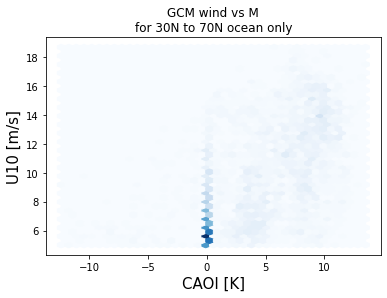

In [265]:
hb = plt.hexbin(xx, yy, gridsize=40, cmap='Blues')
plt.ylabel('U10 [m/s]',fontsize='15')
plt.xlabel('CAOI [K]',fontsize='15')
plt.title('GCM wind vs M\nfor 30N to 70N ocean only')

In [294]:
indx = np.isnan(xx*yy)==False

In [295]:
from scipy import stats
bin_means, bin_edges, binnumber = stats.binned_statistic(xx[indx], yy[indx], 'mean', bins=100)
bin_means_x, bin_edges_x, binnumber_x = stats.binned_statistic(xx[indx], xx[indx], 'mean', bins=100)

bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

mac_bin_means = bin_means[~np.isnan(bin_means)]
mac_bin_centers = bin_centers[~np.isnan(bin_means)]

Text(0.5, 1.0, 'GCM-CESM2')

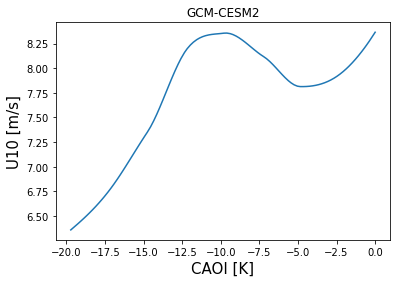

In [296]:
from skmisc.loess import loess
index = np.isnan(bin_means_x*bin_means)==False

# plt.plot(bin_means_x, bin_means)
l = loess(bin_means_x[index], bin_means[index])
l.fit()
pred = l.predict(bin_means_x[index], stderror=True)
conf = pred.confidence()

lowess = pred.values
plt.plot(bin_means_x[index], lowess)
plt.ylabel('U10 [m/s]',fontsize='15')
plt.xlabel('CAOI [K]',fontsize='15')
plt.title('GCM-'+str(av_modname[i]))

In [297]:
bin_means_x_gcm = bin_means_x[index]
bin_means_gcm   = lowess

In [299]:
x_gcm.append(bin_means_x_gcm)
y_gcm.append(bin_means_gcm)

In [298]:
x_gcm = []
y_gcm = []


In [25]:
import glob
merlist = np.sort(glob.glob('../data_merra/lat_30_70/new/MERRA2_*.nc'))
maclist = np.sort(glob.glob('../MACLWP_dailymean/take/wind1deg*.nc4'))

In [26]:
import netCDF4 as nc
import xarray as xr
p_mer_T = []
p_mac_w = []

for i in range(len(merlist)): #len(merlist)
    d_path = merlist[i]
    data   = nc.Dataset(d_path)
    # print(d_path)
    
    if i==0:
        merlat = data.variables['lat'][:]
        merlon = data.variables['lon'][:]
        merlev = data.variables['lev'][:]
        #shape latitude
        mer_lat = np.flip(merlat)
        mer_lat = np.array(mer_lat)
        #shape longitude
        mer_lon = np.array(merlon)
        
        
    merT   = data.variables['T'][:] #(time, lev, lat, lon)
    mer_T = np.array(merT[:,:,::-1,:])
    p_mer_T.extend(mer_T)
    
p_mer_T = np.array(p_mer_T)
temp = np.ma.masked_where(p_mer_T == np.max(p_mer_T), p_mer_T)
# temp = np.ma.compressed(temp)

for i in range(len(maclist)): #len(maclist)
    ddpath = maclist[i]
    ddata  = nc.Dataset(ddpath)
    macw   = ddata.variables['sfcwind'][:] #(time,lat,lon)
    # print(ddpath)
    
    if i==0:
        maclat = ddata.variables['lat'][:]
        maclon = ddata.variables['lon'][:]
        #shape latitude
        mac_lat = np.array(maclat)
        slat_ind1 = np.where(mac_lat == mac_lat.flat[np.abs(mac_lat - (31)).argmin()])[0]
        slat_ind2 = np.where(mac_lat == mac_lat.flat[np.abs(mac_lat - (71)).argmin()])[0]
        p_mac_lat  = np.array(mac_lat[slat_ind1[0]:slat_ind2[0]])
        #shape longitude
        maclon[maclon > 180] = maclon[maclon > 180]-360
        mac_lon = np.array(maclon)
        p_mac_lon = []
        p_mac_lon.extend(mac_lon[180::])
        p_mac_lon.extend(mac_lon[0:180])
        p_mac_lon = np.array(p_mac_lon)
    n_w = macw[:,slat_ind1[0]:slat_ind2[0],180::]
    new_w = np.append(n_w,macw[:,slat_ind1[0]:slat_ind2[0],0:180],2)
    p_mac_w.extend(new_w)

p_mac_w = np.array(p_mac_w)
wind = np.ma.masked_where(p_mac_w == np.min(p_mac_w), p_mac_w)
# wind = np.ma.compressed(wind)
wind = np.ma.masked_where(wind < 5, wind)
# wind = np.ma.compressed(wind)
    

In [27]:
theta_850 = np.array(np.multiply(temp[:,1,:,:], (100/85)**(Rd/Cp)))
p_theta_850 = np.ma.masked_where(theta_850 == np.max(theta_850), theta_850)

# theta_800 = np.array(np.multiply(temp[:,1,:,:], (100/85)**(Rd/Cp)))
# p_theta_800 = np.ma.masked_where(theta_800 == np.max(theta_800), theta_800)

In [28]:
CAOI = np.array(np.subtract(temp[:,0,:,:],p_theta_850))
p_CAOI = np.ma.masked_where(CAOI == np.max(CAOI), CAOI)
p_CAOI = np.ma.masked_where(p_CAOI < -20, p_CAOI)


In [29]:
maskm = np.ones((len(mer_lat),len(mer_lon)))

for a in range(len(mer_lat)):
    for b in range(len(mer_lon)):
        if globe.is_land(mer_lat[a], mer_lon[b])==True:
            maskm[a,b] = 0

In [30]:
plot_CAOI = np.array(np.multiply(maskm,p_CAOI))
plot_CAOI = np.ma.masked_where(plot_CAOI == np.max(plot_CAOI), plot_CAOI)
plot_CAOI = np.ma.masked_where(plot_CAOI < -20, plot_CAOI)

In [31]:
plot_mer_theta = plot_CAOI.ravel()
plot_mac_wind = wind.ravel()

In [32]:
ind = np.argsort(plot_mer_theta)
xx = np.sort(plot_mer_theta)
yy = plot_mac_wind[ind]

In [33]:
indx = np.isnan(xx*yy)==False

In [34]:
bin_means, bin_edges, binnumber = stats.binned_statistic(xx[indx], yy[indx], 'mean', bins=100)
bin_means_x, bin_edges_x, binnumber_x = stats.binned_statistic(xx[indx], xx[indx], 'mean', bins=100)

bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

mac_bin_means = bin_means[~np.isnan(bin_means)]
mac_bin_centers = bin_centers[~np.isnan(bin_means)]

Text(0.5, 1.0, 'observation')

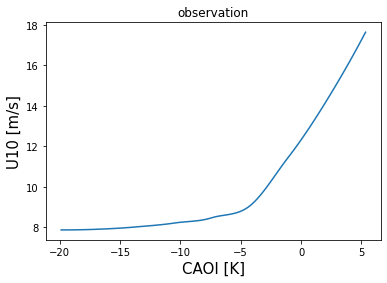

In [35]:
index = np.isnan(bin_means_x*bin_means)==False

# plt.plot(bin_means_x, bin_means)
l = loess(bin_means_x[index], bin_means[index])
l.fit()
pred = l.predict(bin_means_x[index], stderror=True)
conf = pred.confidence()

lowess = pred.values
plt.plot(bin_means_x[index], lowess)
plt.ylabel('U10 [m/s]',fontsize='15')
plt.xlabel('CAOI [K]',fontsize='15')
plt.title('observation')

Text(0.5, 1.0, 'observation')

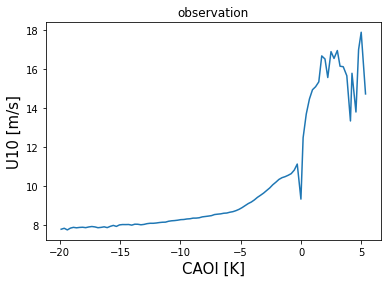

In [36]:
plt.plot(bin_means_x, bin_means)
plt.ylabel('U10 [m/s]',fontsize='15')
plt.xlabel('CAOI [K]',fontsize='15')
plt.title('observation')

In [37]:
bin_means_x_obs = bin_means_x[index]
bin_means_obs   = lowess

Text(0.5, 0, 'CAOI [K]')

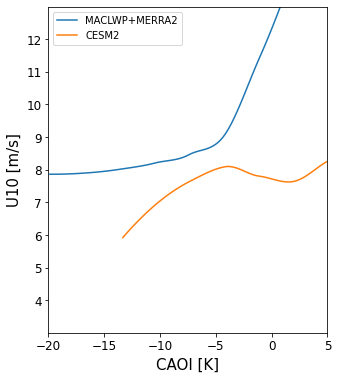

In [227]:
fig= plt.figure(figsize=(5, 6))
plt.plot(bin_means_x_obs, bin_means_obs, label='MACLWP+MERRA2')
plt.plot(bin_means_x_gcm, bin_means_gcm, label='CESM2')
plt.xticks(np.arange(-20,6,5),fontsize='12')
plt.yticks(np.arange(4,13),fontsize='12')
plt.xlim([-20,5])
plt.ylim([3,13])
plt.legend()
plt.ylabel('U10 [m/s]',fontsize='15')
plt.xlabel('CAOI [K]',fontsize='15')
# plt.title('MACLWP wind vs MERRA2 M\nfor 30N to 70N ocean only\n850hPa')

In [39]:
enn = np.arange(0,174)

In [40]:
for en in enn:
    for i in ['U10', 'PSL', 'T850','TS']:
        d_path = '/glade/campaign/cgd/projects/ppe/cam_ppe/rerun_PPE_250/PD/PD_timeseries/PPE_250_ensemble_PD.'+f'{en:03d}'+'/atm/hist/cc_PPE_250_ensemble_PD.'+f'{en:03d}'+'.h0.'+str(i)+'.nc'
        data =xr.open_dataset(d_path)
        
        if en == 0:
            lon  = data.variables['lon'][:]  #(lon: 288) [0.0, 1.25, 2.5, ... 356.25, 357.5, 358.75]
            lat  = data.variables['lat'][:]  #(lat: 192) [-90.0 , -89.057592, -88.115183, ... 88.115183,  89.057592, 90.0]
            time = data.variables['time'][:] #(time: 36)
            
        locals()[str(en)+'_'+i] = data.variables[i][:]

In [41]:
x_lat = np.array(lat)
lat_ind1 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (30)).argmin()])[0]
lat_ind2 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (70)).argmin()])[0]
lat_new  = lat[lat_ind1[0]:lat_ind2[0]]

mask = np.ones((36,len(lat_new),len(lon)))

for a in range(len(lat_new)):
    for b in range(len(lon)):
        if globe.is_land(lat_new[a], lon[b]-180.)==True:
            mask[0:35,a,b] = 0

for en in enn:
    for i in ['U10', 'PSL', 'T850','TS']: #
        tmp  = locals()[str(en)+'_'+i]
        tmp2 = tmp[:,lat_ind1[0]:lat_ind2[0],:]
        locals()['MID'+i+'_'+str(en)] = np.multiply(mask,tmp2)

In [42]:
for en in enn:
    locals()['theta_850_'+str(en)] = np.multiply(locals()['MIDT850_'+str(en)],(np.divide(locals()['MIDPSL_'+str(en)],85000))**(Rd/Cp))

In [43]:
for en in enn:
    locals()['M_'+str(en)]   = np.array(np.subtract(locals()['MIDTS_'+str(en)],locals()['theta_850_'+str(en)])).reshape(-1)
    locals()['U10_'+str(en)] = np.array(locals()['MIDU10_'+str(en)]).reshape(-1)

Text(0.5, 1.0, 'CAM6 PPE')

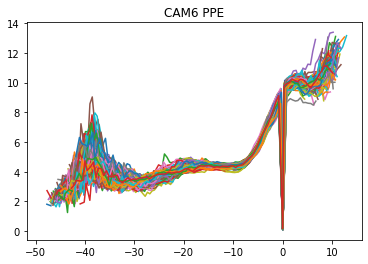

In [44]:
for en in enn:
    x = locals()['M_'+str(en)]
    y = locals()['U10_'+str(en)]
    ind = np.argsort(x)
    xx = np.sort(x)
    yy = y[ind]
    
    indx = np.isnan(xx*yy)==False
    
    bin_means, bin_edges, binnumber = stats.binned_statistic(xx[indx], yy[indx], 'mean', bins=100)
    bin_means_x, bin_edges_x, binnumber_x = stats.binned_statistic(xx[indx], xx[indx], 'mean', bins=100)

    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    
    plt.plot(bin_means_x, bin_means)

# plt.plot(bin_means_x_obs, bin_means_obs, label='MACLWP+MERRA2')
# plt.plot(bin_means_x_gcm, bin_means_gcm, label='CESM2')
# plt.xticks(np.arange(-20,6,5),fontsize='12')
# plt.yticks(np.arange(4,13),fontsize='12')
# plt.xlim([-20,5])
# plt.ylim([3,13])
# plt.legend()
# plt.ylabel('U10 [m/s]',fontsize='15')
# plt.xlabel('CAOI [K]',fontsize='15')
plt.title('CAM6 PPE')

Text(0.5, 0, 'CAOI [K]')

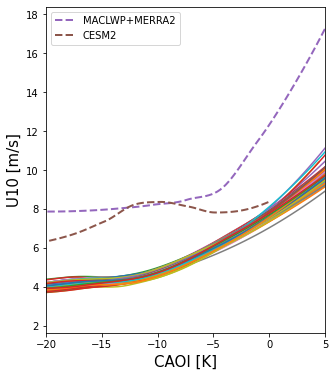

In [300]:
from skmisc.loess import loess
fig= plt.figure(figsize=(5, 6))
for en in enn:
    x = locals()['M_'+str(en)]
    y = locals()['U10_'+str(en)]
    ind = np.argsort(x)
    xx = np.sort(x)
    yy = y[ind]
    
    indx = np.isnan(xx*yy)==False
    
    bin_means, bin_edges, binnumber = stats.binned_statistic(xx[indx], yy[indx], 'mean', bins=100)
    bin_means_x, bin_edges_x, binnumber_x = stats.binned_statistic(xx[indx], xx[indx], 'mean', bins=100)

    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    
    index = np.isnan(bin_means_x*bin_means)==False
    
    # plt.plot(bin_means_x, bin_means)
    l = loess(bin_means_x[index], bin_means[index])
    l.fit()
    pred = l.predict(bin_means_x[index], stderror=True)
    conf = pred.confidence()

    lowess = pred.values
    plt.plot(bin_means_x[index], lowess)


plt.plot(bin_means_x_obs, bin_means_obs, linewidth=2, linestyle='--', label='MACLWP+MERRA2')
plt.plot(bin_means_x_gcm, bin_means_gcm, linewidth=2, linestyle='--', label='CESM2')
# hb2 = plt.hexbin(bin_means_x_gcm, bin_means_gcm, gridsize=40, cmap='Reds')
# hb = plt.hexbin(bin_means_x_obs, bin_means_obs, gridsize=40, cmap='Blues')
# cbar2 = plt.colorbar(hb2,orientation='horizontal')
# cbar = plt.colorbar(hb,  orientation='horizontal')
# cbar2.set_label('gcm density')
# cbar.set_label('obs density')
# plt.xticks(np.arange(-20,6,5),fontsize='12')
# plt.yticks(np.arange(4,13),fontsize='12')
plt.xlim([-20,5])
# plt.ylim([3,13])
plt.legend()
plt.ylabel('U10 [m/s]',fontsize='15')
plt.xlabel('CAOI [K]',fontsize='15')
# plt.savefig('/glade/u/home/geethma/link/output_fig/u10_M.png')
# plt.title('Wind Vs M\nfor 30N to 70N ocean only')

Text(0.5, 0, 'CAOI [K]')

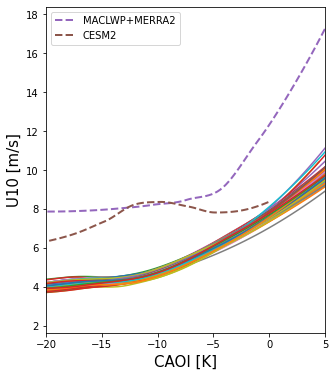

In [301]:
from skmisc.loess import loess
fig= plt.figure(figsize=(5, 6))
for en in enn:
    x = locals()['M_'+str(en)]
    y = locals()['U10_'+str(en)]
    ind = np.argsort(x)
    xx = np.sort(x)
    yy = y[ind]
    
    indx = np.isnan(xx*yy)==False
    
    bin_means, bin_edges, binnumber = stats.binned_statistic(xx[indx], yy[indx], 'mean', bins=100)
    bin_means_x, bin_edges_x, binnumber_x = stats.binned_statistic(xx[indx], xx[indx], 'mean', bins=100)

    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    
    index = np.isnan(bin_means_x*bin_means)==False
    
    # plt.plot(bin_means_x, bin_means)
    l = loess(bin_means_x[index], bin_means[index])
    l.fit()
    pred = l.predict(bin_means_x[index], stderror=True)
    conf = pred.confidence()

    lowess = pred.values
    plt.plot(bin_means_x[index], lowess)


plt.plot(bin_means_x_obs, bin_means_obs, linewidth=2, linestyle='--', label='MACLWP+MERRA2')
plt.plot(bin_means_x_gcm, bin_means_gcm, linewidth=2, linestyle='--', label='CESM2')
# hb2 = plt.hexbin(bin_means_x_gcm, bin_means_gcm, gridsize=40, cmap='Reds')
# hb = plt.hexbin(bin_means_x_obs, bin_means_obs, gridsize=40, cmap='Blues')
# cbar2 = plt.colorbar(hb2,orientation='horizontal')
# cbar = plt.colorbar(hb,  orientation='horizontal')
# cbar2.set_label('gcm density')
# cbar.set_label('obs density')
# plt.xticks(np.arange(-20,6,5),fontsize='12')
# plt.yticks(np.arange(4,13),fontsize='12')
plt.xlim([-20,5])
# plt.ylim([3,13])
plt.legend()
plt.ylabel('U10 [m/s]',fontsize='15')
plt.xlabel('CAOI [K]',fontsize='15')
# plt.savefig('/glade/u/home/geethma/link/output_fig/u10_M_v2.png')
# plt.title('Wind Vs M\nfor 30N to 70N ocean only')

Text(0.5, 1.0, 'wind vs M\nfor 30N to 70N ocean only')

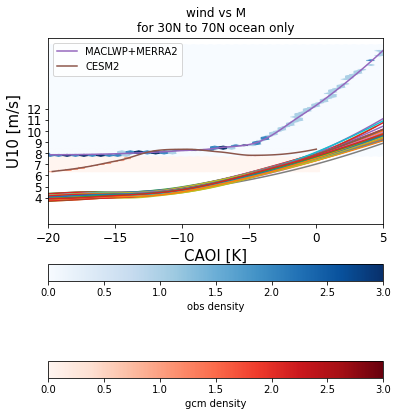

In [318]:
fig= plt.figure(figsize=(6, 7))
for en in enn:
    x = locals()['M_'+str(en)]
    y = locals()['U10_'+str(en)]
    ind = np.argsort(x)
    xx = np.sort(x)
    yy = y[ind]
    
    indx = np.isnan(xx*yy)==False
    
    bin_means, bin_edges, binnumber = stats.binned_statistic(xx[indx], yy[indx], 'mean', bins=100)
    bin_means_x, bin_edges_x, binnumber_x = stats.binned_statistic(xx[indx], xx[indx], 'mean', bins=100)

    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    
    index = np.isnan(bin_means_x*bin_means)==False
    
    # plt.plot(bin_means_x, bin_means)
    l = loess(bin_means_x[index], bin_means[index])
    l.fit()
    pred = l.predict(bin_means_x[index], stderror=True)
    conf = pred.confidence()

    lowess = pred.values
    plt.plot(bin_means_x[index], lowess)

plt.plot(bin_means_x_obs, bin_means_obs, label='MACLWP+MERRA2')
plt.plot(bin_means_x_gcm, bin_means_gcm, label='CESM2')
hb2 = plt.hexbin(bin_means_x_gcm, bin_means_gcm, gridsize=40, cmap='Reds')
hb = plt.hexbin(bin_means_x_obs, bin_means_obs, gridsize=40, cmap='Blues')
cbar2 = plt.colorbar(hb2,orientation='horizontal')
cbar = plt.colorbar(hb,  orientation='horizontal')
cbar2.set_label('gcm density')
cbar.set_label('obs density')
plt.xticks(np.arange(-20,6,5),fontsize='12')
plt.yticks(np.arange(4,13),fontsize='12')
plt.xlim([-20,5])
# plt.ylim([3,13])
plt.legend()
plt.ylabel('U10 [m/s]',fontsize='15')
plt.xlabel('CAOI [K]',fontsize='15')
plt.title('wind vs M\nfor 30N to 70N ocean only')

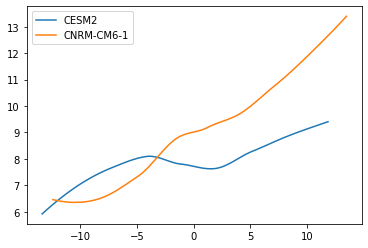

In [271]:
for i in range(0,len(x_gcm)):
    plt.plot(x_gcm[i], y_gcm[i], label=av_modname[i])
    
plt.legend()